# Movie Recommender
Completed by Mike Willis

### Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from nltk.tokenize import word_tokenize
import seaborn as sns
from matplotlib import pyplot as plt

### Read various csv's into dataframes

In [2]:
movies = pd.read_csv('ml-20m/movies.csv')
ratings = pd.read_csv('ml-20m/ratings.csv')
tags = pd.read_csv('ml-20m/tags.csv')

### Data preprocessing and exploration

In [20]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [3]:
# dropping timestamp column as they're not necessary for this project
new_ratings = ratings[['userId', 'movieId', 'rating']]
new_ratings

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000260,138493,69644,3.0
20000261,138493,70286,5.0


In [4]:
# slice ratings to 1M for processing reasons
ratings_1m = new_ratings.iloc[:1000000, :]
ratings_1m

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
999995,6743,1580,4.0
999996,6743,1584,3.0
999997,6743,1586,3.0
999998,6743,1589,4.0


In [5]:
# pivot table of movies IDs, user IDs and user ratings
user_movies_data = ratings_1m.pivot(index='movieId', columns='userId', values='rating').fillna(0)
user_movies_data

userId,1,2,3,4,5,6,7,8,9,10,...,6734,6735,6736,6737,6738,6739,6740,6741,6742,6743
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.5,4.0,4.0,3.0,0.0,4.0,0.0,4.0,0.0,4.0
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create genre_metadata by replacing | with ' '
### Update genre_metadata by replacing (no genres listed) with ' '

In [6]:
movies['genres'] = [re.sub('\|', ' ', words) for words in movies['genres']]
movies['genres'] = [re.sub('\(no genres listed\)', ' ', words) for words in movies['genres']]
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),


In [7]:
# dropping timestamp column as they're not necessary for this project
new_tags = tags[['userId', 'movieId', 'tag']]
new_tags['tag'] = new_tags['tag'].fillna('')
new_tags = new_tags.groupby('movieId')['tag'].apply(' '.join).reset_index()
new_tags

C:\Users\mikew\AppData\Local\Temp/ipykernel_12164/4247669405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_tags['tag'] = new_tags['tag'].fillna('')


,movieId,tag
0,1,Watched computer animation Disney animated fea...
1,2,time travel adapted from:book board game child...
2,3,old people that is actually funny sequel fever...
3,4,chick flick revenge characters chick flick cha...
4,5,Diane Keaton family sequel Steve Martin weddin...
...,...,...
19540,131054,dinosaurs
19541,131082,documentary Yoshitomo Nara
19542,131164,Vietnam War
19543,131170,alternate reality


### Create tags and movie metadata

In [8]:
movies = pd.merge(movies, new_tags, on='movieId', how='left')
movies

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,NaN
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,NaN
27275,131258,The Pirates (2014),Adventure,bandits Korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),,NaN


In [9]:
movies['full_metadata'] = movies['genres'] + ' ' + movies['tag']
movies['full_metadata'] = movies['full_metadata'].fillna('')
movies

,movieId,title,genres,tag,full_metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Adventure Animation Children Comedy Fantasy Wa...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,Adventure Children Fantasy time travel adapted...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...,Comedy Romance old people that is actually fun...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,chick flick revenge characters chick flick cha...,Comedy Drama Romance chick flick revenge chara...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...,Comedy Diane Keaton family sequel Steve Martin...
...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,NaN,
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,NaN,
27275,131258,The Pirates (2014),Adventure,bandits Korea mutiny pirates whale,Adventure bandits Korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),,NaN,


## 1. Popularity Based Filtering

In [32]:
movie_ratings = ratings.groupby('movieId').agg({'userId':'nunique','rating':'mean'})
movie_ratings.rename(columns={'userId':'n_of_votes'},inplace=True)
movie_ratings.head(15)

,n_of_votes,rating
movieId,,
1,49695,3.921240
2,22243,3.211977
3,12735,3.151040
4,2756,2.861393
5,12161,3.064592
6,23899,3.834930
7,12961,3.366484
8,1415,3.142049
9,3960,3.004924


In [33]:
#C is the mean vote across the whole report
C = movie_ratings['rating'].mean()
print(f'C: {C}')

#m is the minimum votes required to be listed
m = movie_ratings['n_of_votes'].quantile(0.9)
print(f'm: {m}')

C: 3.1331999901256933
m: 1305.7000000000007


In [34]:
movie_ratings.drop(movie_ratings[movie_ratings.n_of_votes < m].index, inplace=True)
movie_ratings.head(15)

,n_of_votes,rating
movieId,,
1,49695,3.921240
2,22243,3.211977
3,12735,3.151040
4,2756,2.861393
5,12161,3.064592
6,23899,3.834930
7,12961,3.366484
8,1415,3.142049
9,3960,3.004924


In [35]:
#Calcualting the weighted rating (Popularity Score)
movie_ratings['weighted_rating'] = movie_ratings.apply(lambda x: (x['n_of_votes']*x['rating']+m*C)/(m+x['n_of_votes']), axis=1)

#Selecting the topten movies
top_15 = movie_ratings.sort_values('weighted_rating', ascending=False).head(15)

top_15['movie_name']=movies['title'].loc[top_15.index]
top_15 = top_15[top_15.columns.tolist()[::-1][:1]+top_15.columns.tolist()[:3]]
top_15.drop('rating', axis=1, inplace=True)
top_15

,movie_name,n_of_votes,weighted_rating
movieId,,,
318,Strawberry and Chocolate (Fresa y chocolate) (...,63366,4.420466
858,Killer: A Journal of Murder (1995),41355,4.327039
50,Guardian Angel (1994),47006,4.301909
527,"Secret Garden, The (1993)",50054,4.280253
1221,"Femme Nikita, La (Nikita) (1990)",27398,4.223672
1193,Psycho (1960),29932,4.201478
912,Foreign Correspondent (1940),24349,4.201063
2959,Incredibly True Adventure of Two Girls in Love...,40106,4.192632
904,My Favorite Year (1982),17449,4.192097


## 2. Content Based Filtering

### TF-IDF Vectorizer on Metadata

In [10]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['full_metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies.index.tolist())

In [11]:
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,23853,23854,23855,23856,23857,23858,23859,23860,23861,23862
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
svd = TruncatedSVD(n_components=2000)
latent_matrix = svd.fit_transform(tfidf_df)

In [49]:
latent_matrix_df = pd.DataFrame(latent_matrix[:,0:2000], index = movies['title'].tolist())

### Plot to show how many components returns what variance

In [44]:
explained = svd.explained_variance_ratio_.cumsum()

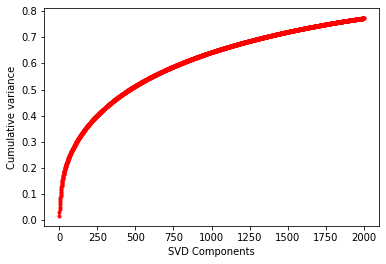

In [45]:
plt.plot(explained, '.-', color='red')
plt.xlabel('SVD Components')
plt.ylabel('Cumulative variance')
plt.show()

## 3. Collaborative Filtering

In [39]:
svd_um = TruncatedSVD(n_components=1000)
latent_matrix_2 = svd_um.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index = movies.title[movies.movieId.isin(user_movies_data.index)])
latent_matrix_2_df

(13950, 1000)

### Plot to show how many components returns what variance

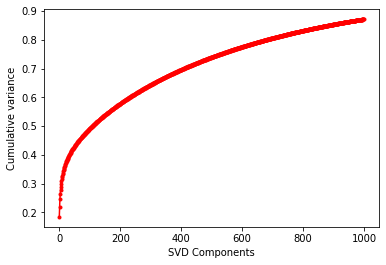

In [29]:
explained_um = svd_um.explained_variance_ratio_.cumsum()
plt.plot(explained_um, '.-', color='red')
plt.xlabel('SVD Components')
plt.ylabel('Cumulative variance')
plt.show()

## Cosine Similarity

In [46]:
# trim latent_matrix_1 to the same size as the pivot table
trim_latent_matrix_1 = pd.DataFrame(latent_matrix, index = movies.movieId)
trim_latent_matrix_1 = trim_latent_matrix_1.loc[user_movies_data.index] 
trim_latent_matrix_1

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.061593,-0.044862,-0.009373,0.111393,0.062366,-0.035557,-0.028855,-0.056432,-0.123487,-0.078856,...,-0.006203,0.008239,-0.004010,0.006151,-0.003878,0.004628,-0.005832,-0.001978,-0.001797,-0.001800
2,0.043077,-0.020919,0.033005,0.059962,0.042723,-0.030717,-0.032359,-0.059905,-0.055491,-0.035528,...,0.000759,-0.000461,-0.003235,-0.000009,-0.001402,0.002939,-0.007703,-0.005996,0.004856,-0.002483
3,0.059892,-0.029795,-0.053004,0.056171,0.012880,-0.022761,0.005052,0.010418,0.006904,0.002788,...,0.021816,-0.002750,-0.007039,-0.005874,-0.004943,0.003701,-0.007083,-0.005061,-0.002361,0.007076
4,0.145303,-0.060155,-0.086761,0.026877,0.035616,-0.077873,-0.002253,-0.000579,0.076570,0.000457,...,-0.001582,-0.002397,0.000032,-0.002832,0.001287,0.004967,-0.001229,0.002566,0.003843,0.000924
5,0.068995,-0.033913,-0.054123,0.091466,0.024534,-0.020765,0.001953,0.023371,-0.025239,-0.001164,...,-0.008411,-0.000751,-0.004243,-0.001482,-0.001728,0.009093,0.002162,-0.009232,0.010207,0.002713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130073,0.126988,-0.057321,0.141320,0.108121,0.052650,-0.057441,-0.072622,-0.217236,-0.092989,-0.144960,...,-0.001816,0.009936,0.007625,0.003095,-0.022871,-0.003803,0.007967,-0.001857,-0.001190,0.019046
130219,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
130462,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


# Putting it all together
### Top 15

In [36]:
top_15

,movie_name,n_of_votes,weighted_rating
movieId,,,
318,Strawberry and Chocolate (Fresa y chocolate) (...,63366,4.420466
858,Killer: A Journal of Murder (1995),41355,4.327039
50,Guardian Angel (1994),47006,4.301909
527,"Secret Garden, The (1993)",50054,4.280253
1221,"Femme Nikita, La (Nikita) (1990)",27398,4.223672
1193,Psycho (1960),29932,4.201478
912,Foreign Correspondent (1940),24349,4.201063
2959,Incredibly True Adventure of Two Girls in Love...,40106,4.192632
904,My Favorite Year (1982),17449,4.192097


### Movie Recommender function showing top 15 similar movies based on movie title and method of sorting (hybrid, content, or collaborative)

In [50]:
def top15_similar_movies(title, method):
    
    a_1 = np.array(latent_matrix_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_content = cosine_similarity(latent_matrix_df, a_1).reshape(-1)
    trim_score_content = cosine_similarity(trim_latent_matrix_1, a_1).reshape(-1)
    score_collab = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # hybrid score: an average score for both content and collaborative 
    hybrid_score = (trim_score_content + score_collab)/2
    
    if method == "hybrid":

        # form a data frame of similar movies 
        dictDF = {'hybrid': hybrid_score}
        similar_movies = pd.DataFrame(dictDF, index = latent_matrix_2_df.index)

        #sort it on the basis of hybrid score
        similar_movies.sort_values('hybrid', ascending = False, inplace = True)
        print(similar_movies.head(15))
    
    if method == "content":
        dictDF = {'content': score_content}
        similar_movies = pd.DataFrame(dictDF, index = latent_matrix_df.index)
        
        #sort it on the basis of content score
        similar_movies.sort_values('content', ascending = False, inplace = True)
        print(similar_movies.head(15))
    
    if method == "collab":
        dictDF = {'collab': score_collab}
        similar_movies = pd.DataFrame(dictDF, index = latent_matrix_2_df.index)
        
        #sort it on the basis of collab score
        similar_movies.sort_values('collab', ascending = False, inplace = True)
        print(similar_movies.head(15))
    
    return None

In [54]:
top15_similar_movies("Toy Story (1995)", "hybrid")

                           hybrid
title                            
Toy Story (1995)         1.000000
Toy Story 2 (1999)       0.743876
Bug's Life, A (1998)     0.673084
Monsters, Inc. (2001)    0.656041
Finding Nemo (2003)      0.632391
Incredibles, The (2004)  0.593313
Ice Age (2002)           0.578059
Ratatouille (2007)       0.524952
Toy Story 3 (2010)       0.519507
Shrek (2001)             0.492826
Up (2009)                0.489059
Cars (2006)              0.453197
Lilo & Stitch (2002)     0.437085
Antz (1998)              0.433839
Lion King, The (1994)    0.426187


In [55]:
top15_similar_movies("Toy Story (1995)", "content")

                              content
Toy Story (1995)             1.000000
Toy Story 2 (1999)           0.947391
Bug's Life, A (1998)         0.879699
Monsters, Inc. (2001)        0.840241
Ice Age (2002)               0.822001
Finding Nemo (2003)          0.801609
Toy Story 3 (2010)           0.779075
Ratatouille (2007)           0.765718
Incredibles, The (2004)      0.759758
Monsters University (2013)   0.709929
Tin Toy (1988)               0.705483
The Legend of Mor'du (2012)  0.705483
Up (2009)                    0.702651
Boundin' (2003)              0.684425
Luxo Jr. (1986)              0.684425


In [57]:
top15_similar_movies("Incredibles, The (2004)", "collab")

                                                      collab
title                                                       
Incredibles, The (2004)                             1.000000
Finding Nemo (2003)                                 0.664911
Monsters, Inc. (2001)                               0.628637
Spider-Man 2 (2004)                                 0.623065
Pirates of the Caribbean: The Curse of the Blac...  0.613180
Lord of the Rings: The Return of the King, The ...  0.607645
Batman Begins (2005)                                0.594454
Shrek (2001)                                        0.587468
Shrek 2 (2004)                                      0.586450
Spider-Man (2002)                                   0.574705
Lord of the Rings: The Two Towers, The (2002)       0.573734
Lord of the Rings: The Fellowship of the Ring, ...  0.567699
Ocean's Eleven (2001)                               0.560356
X2: X-Men United (2003)                             0.559876
Bourne Identity, The (20

## Matrix Factorization Recommender

In [58]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [60]:
R= np.array(ratings_1m.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [61]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 859.2099
Iteration: 40 ; error = 840.9555
Iteration: 60 ; error = 807.7631
Iteration: 80 ; error = 772.8411
Iteration: 100 ; error = 741.8847

P x Q:
[[4.00690286 3.7327386  3.48933242 ... 3.70506011 3.40420339 3.64324214]
 [4.43092382 3.99612987 3.90348358 ... 4.02184257 3.80274965 4.05159844]
 [4.30256965 3.63130244 3.73876694 ... 3.99382708 3.73597427 4.01355691]
 ...
 [3.71963346 2.98178939 2.97805787 ... 3.61199319 3.36778633 3.64289589]
 [4.57008737 3.6725809  3.59059263 ... 4.06223709 3.78409979 4.05538793]
 [3.50469974 3.1211511  2.97195832 ... 3.47135627 3.19656236 3.46402391]]



# Surprise

In [92]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [93]:
movies = pd.read_csv('ml-20m/movies.csv')
ratings = pd.read_csv('ml-20m/ratings.csv')
tags = pd.read_csv('ml-20m/tags.csv')

In [94]:
new_ratings = ratings[['userId', 'movieId', 'rating']]
new_tags = tags[['userId', 'movieId', 'tag']]

In [95]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [96]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.7903


0.7902613339926365

In [98]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(15)        
    else:
        print("User Id does not exist in the list!")
        return None

In [100]:
pred_user_rating(11141)

,ratings
movies,
Fawlty Towers (1975-1979),4.357220
Connections (1978),4.354031
"Best Years of Our Lives, The (1946)",4.343979
Bill Hicks: Revelations (1993),4.339444
Cosmos (1980),4.331217
"Bridge on the River Kwai, The (1957)",4.309802
"Shawshank Redemption, The (1994)",4.298986
"Treasure of the Sierra Madre, The (1948)",4.293514
"Searchers, The (1956)",4.282331


In [101]:
pred_user_rating(1141)

,ratings
movies,
It's Such a Beautiful Day (2012),4.433514
It's a Wonderful Life (1946),4.395113
Prime Suspect (1991),4.386464
"Personal Journey with Martin Scorsese Through American Movies, A (1995)",4.378743
Connections (1978),4.371927
"Piano, The (1993)",4.362404
"Human Condition I, The (Ningen no joken I) (1959)",4.345554
Funky Forest: The First Contact (2005),4.345197
Frozen Planet (2011),4.326180


# Hoping to try out Turicreate in the future!